# Evaluate YOLO v3 on Inferentia

## Introduction
This tutorial walks through compiling and evaluating YOLO v3 model on Inferentia using the AWS Neuron SDK 09/2020 release. We recommend running this tutorial on an EC2 `inf1.2xlarge` instance which contains one Inferentia and 8 vCPU cores, as well as 16 GB of memory.

## Prerequisites
This demo requires the following pip packages:

`neuron-cc tensorflow-neuron pillow matplotlib pycocotools`

and debian/rpm package `aws-neuron-runtime`.

On DLAMI, `aws-neuron-runtime` is already pre-installed.

In [ ]:
!pip install neuron-cc tensorflow-neuron pillow matplotlib pycocotools==2.0.1 --force \
    --extra-index-url=https://pip.repos.neuron.amazonaws.com

## Part 1: Download Dataset and Generate Pretrained SavedModel
### Download COCO 2017 validation dataset
We start by downloading the COCO validation dataset, which we will use to validate our model. The COCO 2017 dataset is widely used for object-detection, segmentation and image captioning.

In [ ]:
!curl -LO http://images.cocodataset.org/zips/val2017.zip
!curl -LO http://images.cocodataset.org/annotations/annotations_trainval2017.zip
!unzip -q val2017.zip
!unzip annotations_trainval2017.zip

In [ ]:
!ls

### Check required package versions
Here are the minimum required versions of AWS Neuron packages. We run a check.

In [ ]:
import pkg_resources
from distutils.version import LooseVersion

assert LooseVersion(pkg_resources.get_distribution('neuron-cc').version) > LooseVersion('1.0.20000')
assert LooseVersion(pkg_resources.get_distribution('tensorflow-neuron').version) > LooseVersion('1.15.3.1.0.2000')
print('passed package version checks')

### Generate YOLO v3 tensorflow SavedModel (pretrained on COCO 2017 dataset)
Script `yolo_v3_coco_saved_model.py` will generate a tensorflow SavedModel using pretrained weights from https://github.com/YunYang1994/tensorflow-yolov3/releases/download/v1.0/yolov3_coco.tar.gz.

In [ ]:
!python3 yolo_v3_coco_saved_model.py ./yolo_v3_coco_saved_model

This tensorflow SavedModel can be loaded as a tensorflow predictor. When a JPEG format image is provided as input, the output result of the tensorflow predictor contains information for drawing bounding boxes and classification results.

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
This function will only be available through the v1 compatibility library as tf.compat.v1.saved_model.loader.load or tf.compat.v1.saved_model.load. There will be a new function for importing SavedModels in Tensorflow 2.0.
INFO:tensorflow:Restoring parameters from ./yolo_v3_coco_saved_model/variables/variables


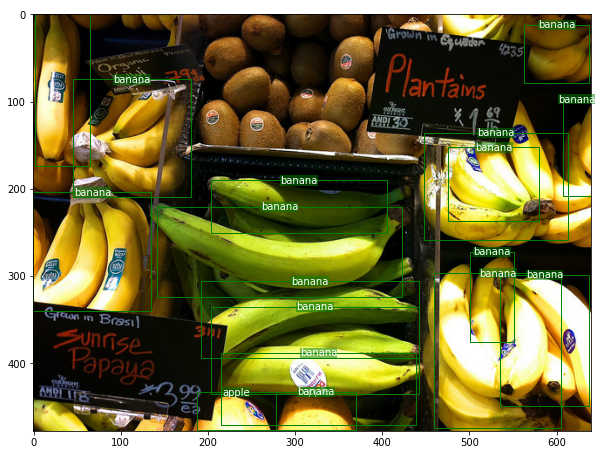

In [1]:
import json
import tensorflow as tf
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# launch predictor and run inference on an arbitrary image in the validation dataset
yolo_pred_cpu = tf.contrib.predictor.from_saved_model('./yolo_v3_coco_saved_model')
image_path = './val2017/000000581781.jpg'
with open(image_path, 'rb') as f:
    feeds = {'image': [f.read()]}
results = yolo_pred_cpu(feeds)

# load annotations to decode classification result
with open('./annotations/instances_val2017.json') as f:
    annotate_json = json.load(f)
label_info = {idx+1: cat['name'] for idx, cat in enumerate(annotate_json['categories'])}

# draw picture and bounding boxes
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(Image.open(image_path).convert('RGB'))
wanted = results['scores'][0] > 0.1
for xyxy, label_no_bg in zip(results['boxes'][0][wanted], results['classes'][0][wanted]):
    xywh = xyxy[0], xyxy[1], xyxy[2] - xyxy[0], xyxy[3] - xyxy[1]
    rect = patches.Rectangle((xywh[0], xywh[1]), xywh[2], xywh[3], linewidth=1, edgecolor='g', facecolor='none')
    ax.add_patch(rect)
    rx, ry = rect.get_xy()
    rx = rx + rect.get_width() / 2.0
    ax.annotate(label_info[label_no_bg + 1], (rx, ry), color='w', backgroundcolor='g', fontsize=10,
                ha='center', va='center', bbox=dict(boxstyle='square,pad=0.01', fc='g', ec='none', alpha=0.5))
plt.show()

## Part 2: Compile the Pretrained SavedModel for Inferentia
We make use of the Python compilation API `tfn.saved_model.compile` that is avaiable in `tensorflow-neuron`. For the purpose of reducing Neuron runtime overhead, it is necessary to make use of arguments `no_fuse_ops` and `minimum_segment_size`.

In [ ]:
import shutil
import tensorflow as tf
import tensorflow.neuron as tfn


def no_fuse_condition(op):
    return op.name.startswith('Preprocessor') or op.name.startswith('Postprocessor')

with tf.Session(graph=tf.Graph()) as sess:
    tf.saved_model.loader.load(sess, ['serve'], './yolo_v3_coco_saved_model')
    no_fuse_ops = [op.name for op in sess.graph.get_operations() if no_fuse_condition(op)]
shutil.rmtree('./yolo_v3_coco_saved_model_neuron', ignore_errors=True)
result = tfn.saved_model.compile(
    './yolo_v3_coco_saved_model', './yolo_v3_coco_saved_model_neuron',
    # to enforce trivial compilable subgraphs to run on CPU
    no_fuse_ops=no_fuse_ops,
    minimum_segment_size=100,
    batch_size=2,
    dynamic_batch_size=True,
)
print(result)

## Part 3: Evaluate Model Quality after Compilation
### Define evaluation functions
We first define some handy helper functions for running evaluation on the COCO 2017 dataset.

In [ ]:
import os
import json
import time
import numpy as np
import tensorflow as tf
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval


def cocoapi_eval(jsonfile,
                 style,
                 coco_gt=None,
                 anno_file=None,
                 max_dets=(100, 300, 1000)):
    """
    Args:
        jsonfile: Evaluation json file, eg: bbox.json, mask.json.
        style: COCOeval style, can be `bbox` , `segm` and `proposal`.
        coco_gt: Whether to load COCOAPI through anno_file,
                 eg: coco_gt = COCO(anno_file)
        anno_file: COCO annotations file.
        max_dets: COCO evaluation maxDets.
    """
    assert coco_gt is not None or anno_file is not None

    if coco_gt is None:
        coco_gt = COCO(anno_file)
    print("Start evaluate...")
    coco_dt = coco_gt.loadRes(jsonfile)
    if style == 'proposal':
        coco_eval = COCOeval(coco_gt, coco_dt, 'bbox')
        coco_eval.params.useCats = 0
        coco_eval.params.maxDets = list(max_dets)
    else:
        coco_eval = COCOeval(coco_gt, coco_dt, style)
    coco_eval.evaluate()
    coco_eval.accumulate()
    coco_eval.summarize()
    return coco_eval.stats


def bbox_eval(anno_file, bbox_list):
    coco_gt = COCO(anno_file)

    outfile = 'bbox_detections.json'
    print('Generating json file...')
    with open(outfile, 'w') as f:
        json.dump(bbox_list, f)

    map_stats = cocoapi_eval(outfile, 'bbox', coco_gt=coco_gt)
    return map_stats


def get_image_as_bytes(images, eval_pre_path):
    batch_im_id_list = []
    batch_im_name_list = []
    batch_img_bytes_list = []
    n = len(images)
    batch_im_id = []
    batch_im_name = []
    batch_img_bytes = []
    for i, im in enumerate(images):
        im_id = im['id']
        file_name = im['file_name']
        if i % eval_batch_size == 0 and i != 0:
            batch_im_id_list.append(batch_im_id)
            batch_im_name_list.append(batch_im_name)
            batch_img_bytes_list.append(batch_img_bytes)
            batch_im_id = []
            batch_im_name = []
            batch_img_bytes = []
        batch_im_id.append(im_id)
        batch_im_name.append(file_name)

        with open(os.path.join(eval_pre_path, file_name), 'rb') as f:
            batch_img_bytes.append(f.read())
    return batch_im_id_list, batch_im_name_list, batch_img_bytes_list


def analyze_bbox(results, batch_im_id, _clsid2catid):
    bbox_list = []
    k = 0
    for boxes, scores, classes in zip(results['boxes'], results['scores'], results['classes']):
        if boxes is not None:
            im_id = batch_im_id[k]
            n = len(boxes)
            for p in range(n):
                clsid = classes[p]
                score = scores[p]
                xmin, ymin, xmax, ymax = boxes[p]
                catid = (_clsid2catid[int(clsid)])
                w = xmax - xmin + 1
                h = ymax - ymin + 1

                bbox = [xmin, ymin, w, h]
                # Round to the nearest 10th to avoid huge file sizes, as COCO suggests
                bbox = [round(float(x) * 10) / 10 for x in bbox]
                bbox_res = {
                    'image_id': im_id,
                    'category_id': catid,
                    'bbox': bbox,
                    'score': float(score),
                }
                bbox_list.append(bbox_res)
        k += 1
    return bbox_list

Here is the actual evaluation loop. To fully utilize all four cores on one Inferentia, the optimal setup is to run multi-threaded inference using a `ThreadPoolExecutor`. The following cell is a multi-threaded adaptation of the evaluation routine at https://github.com/miemie2013/Keras-YOLOv4/blob/910c4c6f7265f5828fceed0f784496a0b46516bf/tools/cocotools.py#L97.

In [ ]:
from concurrent import futures

def evaluate(yolo_predictor, images, eval_pre_path, anno_file, eval_batch_size, _clsid2catid):
    batch_im_id_list, batch_im_name_list, batch_img_bytes_list = get_image_as_bytes(images, eval_pre_path)

    # warm up
    yolo_predictor({'image': np.array(batch_img_bytes_list[0], dtype=object)})

    with futures.ThreadPoolExecutor(4) as exe:
        fut_im_list = []
        fut_list = []
        start_time = time.time()
        for batch_im_id, batch_im_name, batch_img_bytes in zip(batch_im_id_list, batch_im_name_list, batch_img_bytes_list):
            if len(batch_img_bytes) != eval_batch_size:
                continue
            fut = exe.submit(yolo_predictor, {'image': np.array(batch_img_bytes, dtype=object)})
            fut_im_list.append((batch_im_id, batch_im_name))
            fut_list.append(fut)
        bbox_list = []
        count = 0
        for (batch_im_id, batch_im_name), fut in zip(fut_im_list, fut_list):
            results = fut.result()
            bbox_list.extend(analyze_bbox(results, batch_im_id, _clsid2catid))
            for _ in batch_im_id:
                count += 1
                if count % 100 == 0:
                    print('Test iter {}'.format(count))
        print('==================== Performance Measurement ====================')
        print('Finished inference on {} images in {} seconds'.format(len(images), time.time() - start_time))
        print('=================================================================')
    # start evaluation
    box_ap_stats = bbox_eval(anno_file, bbox_list)
    return box_ap_stats

### Evaluate mean average precision (mAP) score
Here is the code to calculate mAP scores of the YOLO v3 model. The expected mAP score is around 0.328 if we use the pretrained weights.

In [ ]:
yolo_pred = tf.contrib.predictor.from_saved_model('./yolo_v3_coco_saved_model_neuron')

val_coco_root = './val2017'
val_annotate = './annotations/instances_val2017.json'
clsid2catid = {0: 1, 1: 2, 2: 3, 3: 4, 4: 5, 5: 6, 6: 7, 7: 8, 8: 9, 9: 10, 10: 11, 11: 13, 12: 14, 13: 15, 14: 16,
               15: 17, 16: 18, 17: 19, 18: 20, 19: 21, 20: 22, 21: 23, 22: 24, 23: 25, 24: 27, 25: 28, 26: 31,
               27: 32, 28: 33, 29: 34, 30: 35, 31: 36, 32: 37, 33: 38, 34: 39, 35: 40, 36: 41, 37: 42, 38: 43,
               39: 44, 40: 46, 41: 47, 42: 48, 43: 49, 44: 50, 45: 51, 46: 52, 47: 53, 48: 54, 49: 55, 50: 56,
               51: 57, 52: 58, 53: 59, 54: 60, 55: 61, 56: 62, 57: 63, 58: 64, 59: 65, 60: 67, 61: 70, 62: 72,
               63: 73, 64: 74, 65: 75, 66: 76, 67: 77, 68: 78, 69: 79, 70: 80, 71: 81, 72: 82, 73: 84, 74: 85,
               75: 86, 76: 87, 77: 88, 78: 89, 79: 90}
eval_batch_size = 8
with open(val_annotate, 'r', encoding='utf-8') as f2:
    for line in f2:
        line = line.strip()
        dataset = json.loads(line)
        images = dataset['images']
box_ap = evaluate(yolo_pred, images, val_coco_root, val_annotate, eval_batch_size, clsid2catid)